In [1]:
pip install --upgrade lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Here we load files
df_train = pd.read_parquet('/kaggle/input/training-and-testing-dataset/train.parquet')
df_test = pd.read_parquet('/kaggle/input/training-and-testing-dataset//test.parquet')


In [11]:
# Checking basic info about the training dataset
print(df_train.describe())
print(df_train.info())
print(df_train.head())


                                Date            X1            X2  \
count                        1639424  1.639424e+06  1.639424e+06   
mean   2022-12-03 07:23:43.817145600  1.139258e+00  5.488189e+00   
min              2020-12-16 00:00:00  1.000000e+00  5.412539e+00   
25%              2021-12-10 00:00:00  1.049171e+00  5.480597e+00   
50%              2022-11-30 00:00:00  1.105171e+00  5.488979e+00   
75%              2023-11-23 00:00:00  1.214096e+00  5.496717e+00   
max              2024-12-11 00:00:00  4.014850e+00  5.541852e+00   
std                              NaN  1.391992e-01  1.342811e-02   

                 X3            X4            X5  
count  1.639424e+06  1.639424e+06  1.639424e+06  
mean   4.110388e+32  2.706323e+29  1.187219e+00  
min    1.000000e+00  1.000000e+00  0.000000e+00  
25%    1.000000e+00  1.000000e+00  0.000000e+00  
50%    1.000000e+00  1.000000e+00  6.931472e-01  
75%    1.000000e+00  2.718282e+00  2.890372e+00  
max    1.651636e+38  5.540622e+34  3.


Sample shape: (1000000, 7)
Sample summary:


,Date,X1,X2,X3,X4,X5
count,1000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000
mean,2022-12-03 10:29:41.078400,1.139266,5.488188,4.211530e+32,2.254851e+29,1.187536
min,2020-12-16 00:00:00,1.000000,5.412539,1.000000e+00,1.000000e+00,0.000000
25%,2021-12-10 00:00:00,1.049171,5.480597,1.000000e+00,1.000000e+00,0.000000
50%,2022-11-30 00:00:00,1.105171,5.488938,1.000000e+00,1.000000e+00,0.693147
75%,2023-11-24 00:00:00,1.214096,5.496717,1.000000e+00,2.718282e+00,2.890372
max,2024-12-11 00:00:00,3.287081,5.541028,1.651636e+38,2.038281e+34,3.465736
std,NaN,0.139108,0.013430,2.424079e+35,3.366872e+31,1.304951



Target distribution in sample:
target
0    0.991452
1    0.008548
Name: proportion, dtype: float64


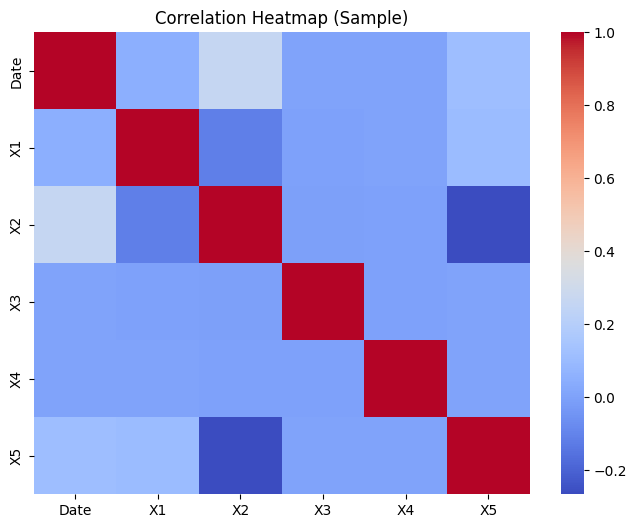

In [17]:
# some basic EDA to find out a sub-sample of the training dataset so that i can identify which variables may result in multicolinearity

sample_size = 1000000 
train_sample = df_train.sample(n=sample_size, random_state=42)

print("\nSample shape:", train_sample.shape)
print("Sample summary:")
display(train_sample.describe())

print("\nTarget distribution in sample:")
print(train_sample["target"].value_counts(normalize=True))

numeric_cols = [col for col in train_sample.columns if col not in ["target", "ID"]]
corr_matrix = train_sample[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Sample)")
plt.show()

In [20]:
# Target distribution in sample:
# target
# 0    0.991452
# 1    0.008548
# Name: proportion, dtype: float64



# We got the above result from the sample distribution, and we can get an idea from this that 
# the dataset provided is highly imbalanced with around 
# 99.14% of data points belonging to class 0.
# and around 0.85% of data points belong to class 1.

In [22]:
for df in [df_train, df_test]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['weekday'] = df['Date'].dt.weekday

#in our original daaset, we saw that target column was an object which had categorical data,
#so i converted it to int type for ease.
df_train['target'] = df_train['target'].astype(int)

# finding all missing values and outliers
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Date       0
X1         0
X2         0
X3         0
X4         0
X5         0
target     0
day        0
month      0
year       0
weekday    0
dtype: int64
ID         0
Date       0
X1         0
X2         0
X3         0
X4         0
X5         0
day        0
month      0
year       0
weekday    0
dtype: int64


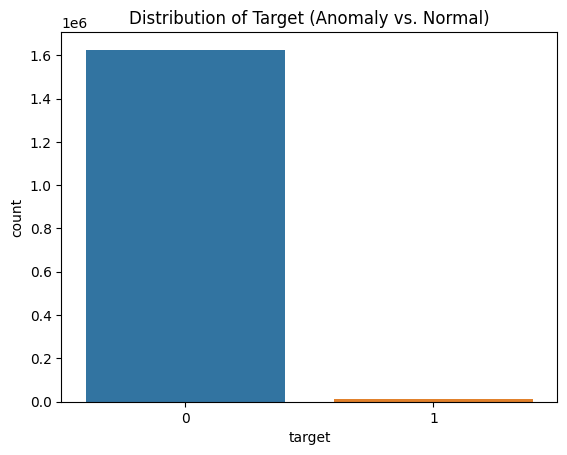

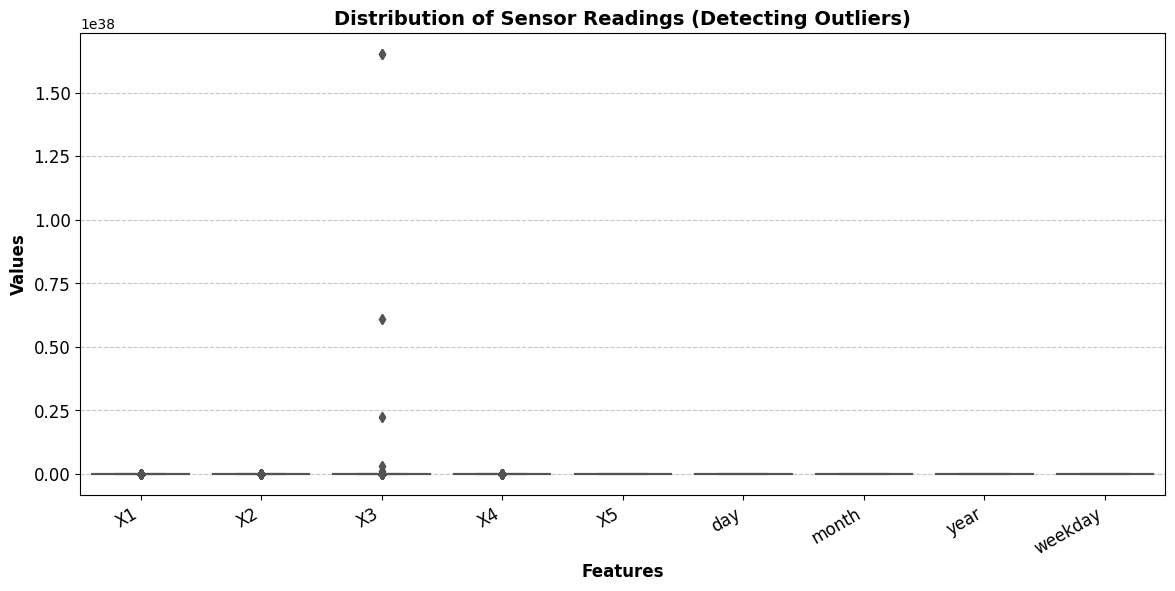

In [27]:
# Feature Engineering

features = ['X1', 'X2', 'X3', 'X4', 'X5', 'day', 'month', 'year', 'weekday']
X = df_train[features]
y = df_train['target']

sns.countplot(x='target', data=df_train)
plt.title("Distribution of Target (Anomaly vs. Normal)")
plt.show()

plt.figure(figsize=(14, 6))  
sns.boxplot(data=X, palette="coolwarm")  
plt.xticks(rotation=30, ha="right", fontsize=12)  
plt.yticks(fontsize=12) 
plt.title('Distribution of Sensor Readings (Detecting Outliers)', fontsize=14, fontweight='bold')  
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Values', fontsize=12, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)  
plt.show()

In [28]:
# Train and test split for validation

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2, 
                                                  stratify=y, 
                                                  random_state=42
                                                 )


In [32]:
# I chose LightGBM for several key reasons:

# since my dataset was very large-scale with over 1.6 million entries, 
# i found it extremely challenging to train the data on even a GPU in Google Collab,
# after multiple failed attempts, i finally thought of using LightGBM as it is very fast 
# and uses a histogram-based algorithm that speeds up training and reduces memory usage.

# Gradient boosting methods, and LightGBM in particular, is well-known for its strong performance on tabular data. 
# It can capture complex nonlinear interactions among features without the need for extensive feature engineering.

# And lastly and most importantly, when I performed EDA on a sample of the training dataset, 
# i saw that there was a high imbalance in the target distribution.
# LightGBM provides parameters (like is_unbalance or scale_pos_weight) that help adjust for imbalanced classes.

In [33]:
# Defining LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss', 
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
}

In [34]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.0246268	valid's binary_logloss: 0.0246382
[100]	train's binary_logloss: 0.0200079	valid's binary_logloss: 0.0200664
[150]	train's binary_logloss: 0.0177516	valid's binary_logloss: 0.0178662
[200]	train's binary_logloss: 0.0164439	valid's binary_logloss: 0.0166343
[250]	train's binary_logloss: 0.0156084	valid's binary_logloss: 0.0158514
[300]	train's binary_logloss: 0.0150104	valid's binary_logloss: 0.0153038
[350]	train's binary_logloss: 0.0145563	valid's binary_logloss: 0.0148993
[400]	train's binary_logloss: 0.0141827	valid's binary_logloss: 0.0145913
[450]	train's binary_logloss: 0.0138684	valid's binary_logloss: 0.0143501
[500]	train's binary_logloss: 0.0136036	valid's binary_logloss: 0.0141569
[550]	train's binary_logloss: 0.0133634	valid's binary_logloss: 0.0139865
[600]	train's binary_logloss: 0.0131454	valid's binary_logloss: 0.0138386
[650]	train's binary_logloss: 0.0129597	valid's bin

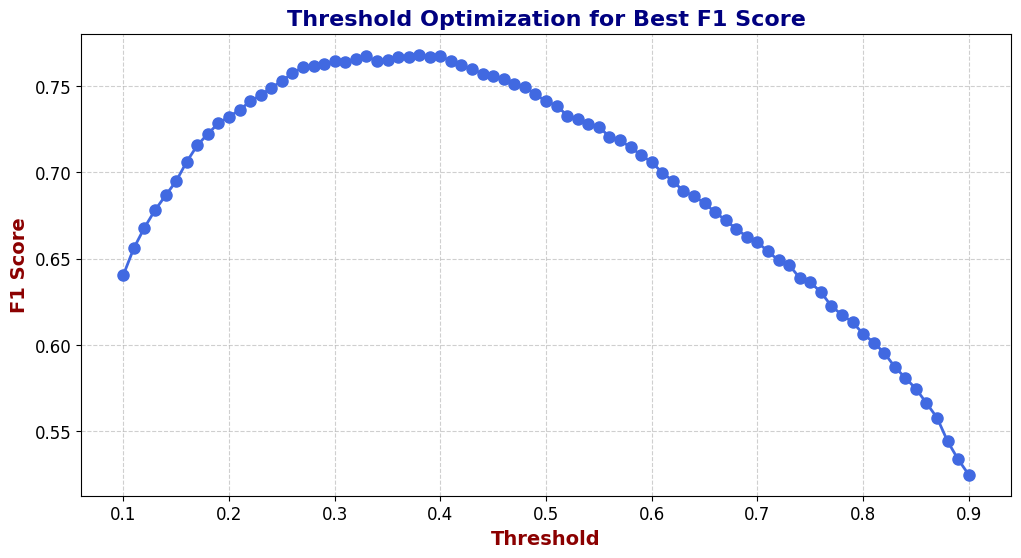

In [40]:
# import lightgbm as lgb
# print("LightGBM version:", lgb.__version__)

callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=50)]

model = lgb.train(params,
                  lgb_train,
                  num_boost_round=2000,
                  valid_sets=[lgb_train, lgb_val],
                  valid_names=['train', 'valid'],
                  callbacks=callbacks)

val_preds_proba = model.predict(X_val, num_iteration=model.best_iteration)

# here we will find the best threshold that maximizes the F1 score
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []
for th in thresholds:
    preds = (val_preds_proba >= th).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)
print("Validation F1 Score:", np.max(f1_scores))

plt.figure(figsize=(12, 6))  
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8)  

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkred')  
plt.ylabel("F1 Score", fontsize=14, fontweight='bold', color='darkred')  
plt.title("Threshold Optimization for Best F1 Score", fontsize=16, fontweight='bold', color='navy')  

plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.6) 

plt.show()


In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X.shape[0])

for train_idx, valid_idx in skf.split(X, y):
    X_tr, X_va = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[valid_idx]
    
    lgb_train_cv = lgb.Dataset(X_tr, label=y_tr)
    lgb_val_cv = lgb.Dataset(X_va, label=y_va, reference=lgb_train_cv)
    
    # We will use     callbacks for early stopping
    callbacks_cv = [lgb.early_stopping(stopping_rounds=100)]
    
    model_cv = lgb.train(
        params,
        lgb_train_cv,
        num_boost_round=2000,
        valid_sets=[lgb_train_cv, lgb_val_cv],
        valid_names=['train', 'valid'],
        callbacks=callbacks_cv,
    )
    
    oof_preds[valid_idx] = model_cv.predict(X_va, num_iteration=model_cv.best_iteration)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's binary_logloss: 0.00990059	valid's binary_logloss: 0.0124727
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's binary_logloss: 0.00993649	valid's binary_logloss: 0.0120646
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's binary_logloss: 0.00994951	valid's binary_logloss: 0.0121171
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's binary_logloss: 0.0099837	valid's binary_logloss: 0.0122011
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's binary_logloss: 0.00987024	valid's binary_logloss: 0.0125034


In [44]:
cv_f1 = f1_score(y, (oof_preds >= best_threshold).astype(int))
print("Cross-Validation F1 Score:", cv_f1)


X_test = df_test[features]
test_preds_proba = model.predict(X_test, num_iteration=model.best_iteration)
test_preds = (test_preds_proba >= best_threshold).astype(int)

# submission DataFrame
submission = pd.DataFrame({
    'ID': df_test['ID'],
    'Prediction': test_preds
})
submission.head()

# Save submission to CSV
submission.to_csv('submission_grand_final.csv', index=False)

Cross-Validation F1 Score: 0.7606503556632533
